# RNNs
### Reference: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

# Task - Classifying Names with a Character-Level RNN

The task is to identify the nationality of an input name.




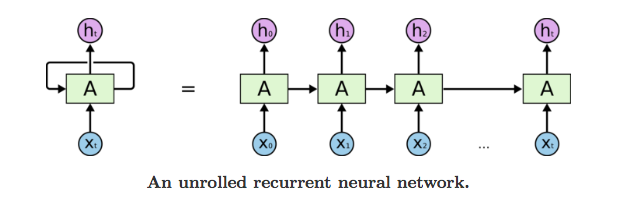

## Types of RNNs
There are different uses of an RNN, and in this tutorial we are going to look at one example of many-to-one RNN

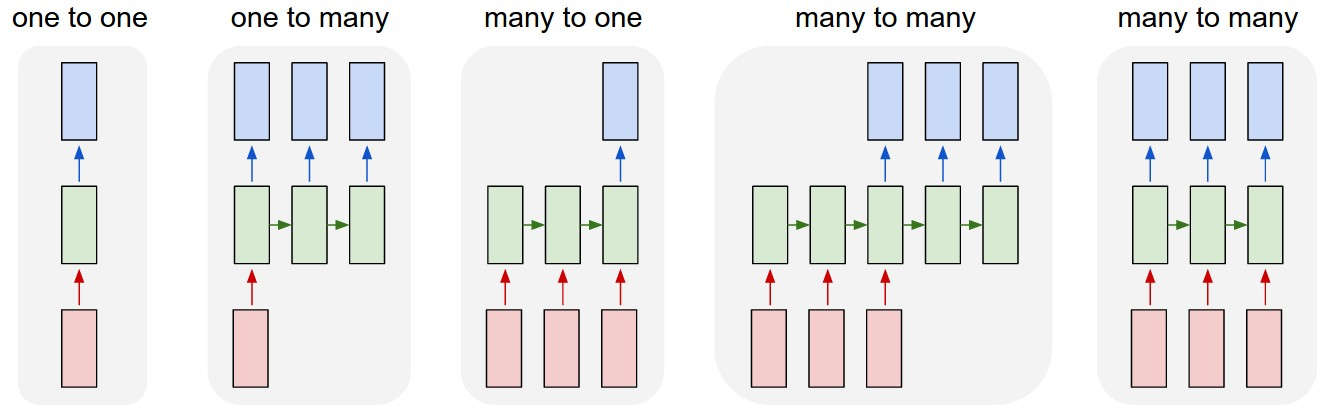

# Data Preparation
Download file in this [link](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fdownload.pytorch.org%2Ftutorial%2Fdata.zip)

In [1]:
!unzip data.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
%matplotlib inline
from io import open
import glob
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))


['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


### Read all files

In [6]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print("Num Categories:", n_categories)

Num Categories: 18


### Example of instances with Italian

In [7]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Converting Characters to Tensors

In [8]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

print(lineToTensor("Jones"))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.,

# Creating an RNN (Vanilla RNN)

In [9]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [10]:
rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

### Sample Run

In [7]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [8]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9286, -2.8850, -2.8963, -2.9507, -2.9082, -2.9503, -2.8544, -2.8432,
         -2.8818, -2.9072, -2.8138, -2.9766, -2.9737, -2.8515, -2.8402, -2.7843,
         -2.9177, -2.8879]], grad_fn=<LogSoftmaxBackward0>)


In [9]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Scottish', 15)


### Creating Batch

In [10]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = English / line = Given
category = Italian / line = Alesi
category = Irish / line = Neil
category = Spanish / line = Del olmo
category = Russian / line = Hairullov
category = Scottish / line = Kelly
category = Korean / line = Rheem
category = Czech / line = Slepica
category = Polish / line = Jelen
category = Chinese / line = OuYang


### Training

In [11]:
criterion = nn.NLLLoss()

In [12]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [13]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.9270 Blumenthal / Chinese ✗ (German)
10000 10% (0m 14s) 2.1950 Riain / Scottish ✗ (Irish)
15000 15% (0m 21s) 2.4491 Normington / Russian ✗ (English)
20000 20% (0m 28s) 0.2364 Pappayiorgas / Greek ✓
25000 25% (0m 36s) 0.6344 Kong / Chinese ✓
30000 30% (0m 45s) 0.1111 Nishihara / Japanese ✓
35000 35% (0m 54s) 1.5603 O'Connell / Scottish ✗ (Irish)
40000 40% (1m 3s) 0.8000 Zabek / Polish ✓
45000 45% (1m 11s) 0.8386 Guerra / Portuguese ✓
50000 50% (1m 18s) 0.8282 Serechenko / Russian ✓
55000 55% (1m 25s) 0.5745 Koury / Arabic ✓
60000 60% (1m 33s) 5.7038 Boutros / Greek ✗ (Arabic)
65000 65% (1m 40s) 2.9807 Blades / Portuguese ✗ (Greek)
70000 70% (1m 49s) 2.1803 Trew / Vietnamese ✗ (English)
75000 75% (1m 57s) 0.9511 Hovanec / Czech ✓
80000 80% (2m 5s) 2.6692 Rey / English ✗ (French)
85000 85% (2m 14s) 1.1672 Achteren / Dutch ✓
90000 90% (2m 21s) 0.0790 Vu / Vietnamese ✓
95000 95% (2m 28s) 1.5862 Komura / Japanese ✓
100000 100% (2m 36s) 0.9008 Neisser / Czech ✓


### Plotting Results

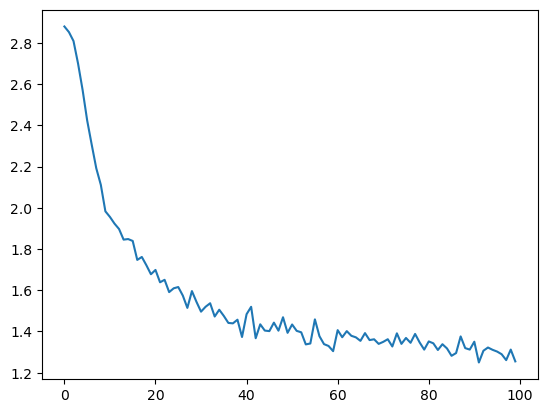

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Evaluating

C:\Users\lzhang\AppData\Local\Temp\ipykernel_11024\3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\lzhang\AppData\Local\Temp\ipykernel_11024\3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


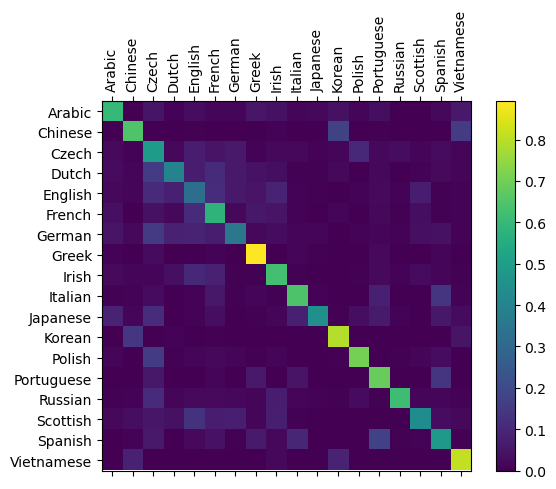

In [15]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### Test

In [16]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

import math

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (math.exp(value), all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Lee')
predict('Jackson')
predict('Satoshi')


> Lee
(0.53) Chinese
(0.16) Vietnamese
(0.15) Korean

> Jackson
(0.60) Scottish
(0.19) Czech
(0.12) English

> Satoshi
(0.28) Japanese
(0.25) Arabic
(0.25) Italian


# LSTM - RNN with GATES

Code from [link](https://theaisummer.com/understanding-lstm/)

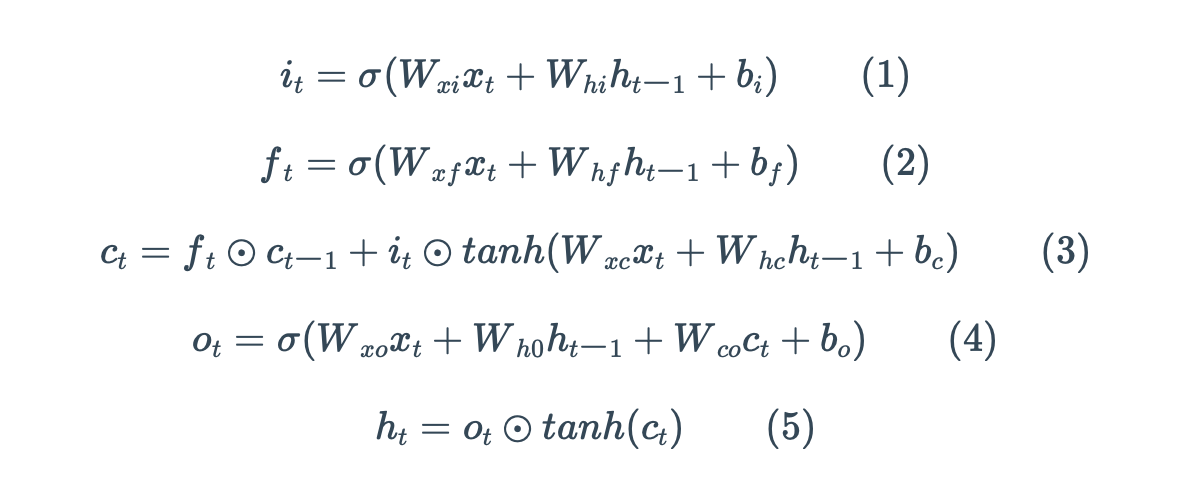

In [17]:
import torch
from torch import nn

class LSTM(torch.nn.Module):
    """
    A simple LSTM cell network for educational AI-summer purposes
    """
    def __init__(self, input_length=10, hidden_length=20):
        super(LSTM, self).__init__()
        self.input_length = input_length
        self.hidden_length = hidden_length

        # forget gate components
        self.linear_forget_w1 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_forget_r1 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid_forget = nn.Sigmoid()

        # input gate components
        self.linear_gate_w2 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_gate_r2 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid_gate = nn.Sigmoid()

        # cell memory components
        self.linear_gate_w3 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_gate_r3 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.activation_gate = nn.Tanh()

        # out gate components
        self.linear_gate_w4 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_gate_r4 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid_hidden_out = nn.Sigmoid()

        self.activation_final = nn.Tanh()

    def forget(self, x, h):
        x = self.linear_forget_w1(x)
        h = self.linear_forget_r1(h)
        return self.sigmoid_forget(x + h)

    def input_gate(self, x, h):

        # Equation 1. input gate
        x_temp = self.linear_gate_w2(x)
        h_temp = self.linear_gate_r2(h)
        i = self.sigmoid_gate(x_temp + h_temp)
        return i

    def cell_memory_gate(self, i, f, x, h, c_prev):
        x = self.linear_gate_w3(x)
        h = self.linear_gate_r3(h)

        # new information part that will be injected in the new context
        k = self.activation_gate(x + h)
        g = k * i

        # forget old context/cell info
        c = f * c_prev
        # learn new context/cell info
        c_next = g + c
        return c_next

    def out_gate(self, x, h):
        x = self.linear_gate_w4(x)
        h = self.linear_gate_r4(h)
        return self.sigmoid_hidden_out(x + h)

    def forward(self, x, tuple_in ):
        (h, c_prev) = tuple_in
        # Equation 1. input gate
        i = self.input_gate(x, h)

        # Equation 2. forget gate
        f = self.forget(x, h)

        # Equation 3. updating the cell memory
        c_next = self.cell_memory_gate(i, f, x, h,c_prev)

        # Equation 4. calculate the main output gate
        o = self.out_gate(x, h)


        # Equation 5. produce next hidden output
        h_next = o * self.activation_final(c_next)

        return h_next, c_next